In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "training",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
for image_batch, labels_batch in dataset.take(1):
       print(image_batch.shape)
       print(labels_batch.numpy())

(32, 256, 256, 3)
[1 2 0 0 1 1 2 0 0 1 0 0 1 1 0 0 1 1 2 2 1 0 2 0 0 0 1 2 1 1 0 1]


(32, 256, 256, 3)
[0 0 1 0 0 0 0 0 0 1 1 1 0 1 1 1 0 0 1 1 2 0 1 0 1 0 0 1 1 1 1 1]


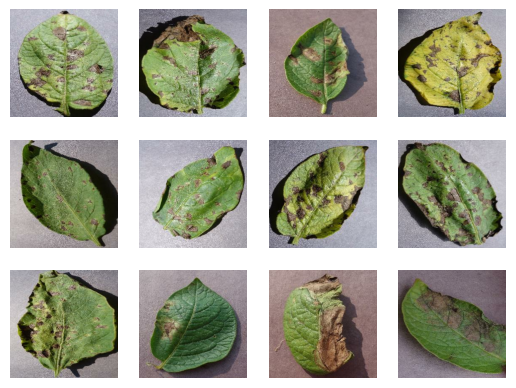

In [8]:
for image_batch, labels_batch in dataset.take(1):
       print(image_batch.shape)
       print(labels_batch.numpy())
       for i in range(12):
           ax = plt.subplot(3,4,i+1)
           plt.imshow(image_batch[i].numpy().astype("uint8"))
           plt.axis("off")

(32, 256, 256, 3)
[0 0 0 1 0 0 1 0 2 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 1 0]


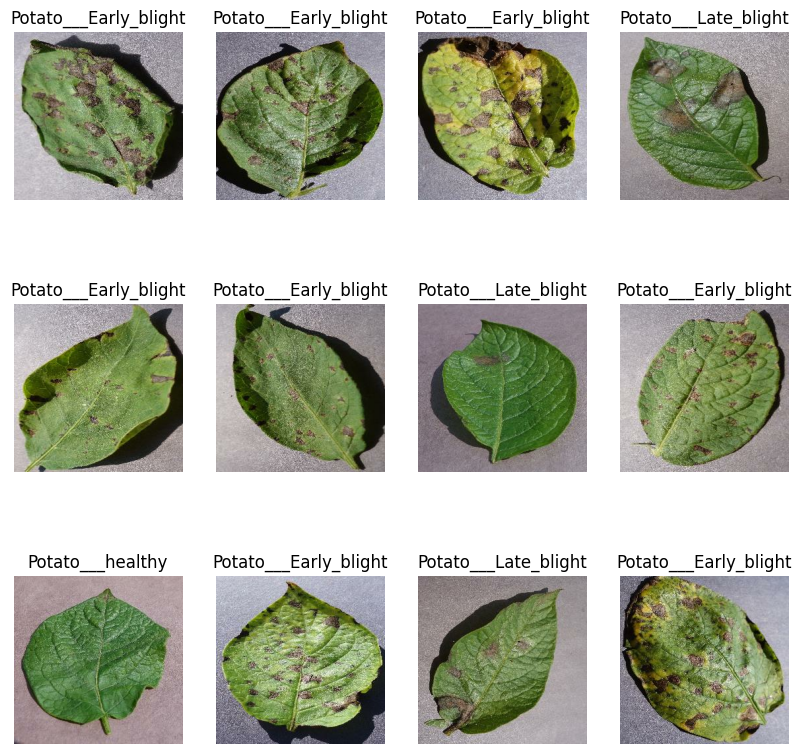

In [9]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
       print(image_batch.shape)
       print(labels_batch.numpy())
       for i in range(12):
           ax = plt.subplot(3,4,i+1)
           plt.imshow(image_batch[i].numpy().astype("uint8"))
           plt.title(class_names[labels_batch[i]])
           plt.axis("off")

In [10]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [11]:
train_ds = dataset.take(54)
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [13]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert(train_split+test_split+val_split) ==1
    
    ds_size = len(ds)

    if  shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
]
)

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
]
)

In [21]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy()/255)

[[[0.49803922 0.47843137 0.5019608 ]
  [0.5411765  0.52156866 0.54509807]
  [0.54901963 0.5294118  0.5529412 ]
  ...
  [0.7137255  0.7058824  0.7254902 ]
  [0.69803923 0.6901961  0.70980394]
  [0.6784314  0.67058825 0.6901961 ]]

 [[0.5372549  0.5176471  0.5411765 ]
  [0.5294118  0.50980395 0.53333336]
  [0.5411765  0.52156866 0.54509807]
  ...
  [0.70980394 0.7019608  0.72156864]
  [0.69411767 0.6862745  0.7058824 ]
  [0.6745098  0.6666667  0.6862745 ]]

 [[0.59607846 0.5764706  0.6       ]
  [0.5686275  0.54901963 0.57254905]
  [0.5921569  0.57254905 0.59607846]
  ...
  [0.7019608  0.69411767 0.7137255 ]
  [0.6901961  0.68235296 0.7019608 ]
  [0.6745098  0.6666667  0.6862745 ]]

 ...

 [[0.5529412  0.5411765  0.5686275 ]
  [0.5882353  0.5764706  0.6039216 ]
  [0.5372549  0.5254902  0.5529412 ]
  ...
  [0.627451   0.6156863  0.6431373 ]
  [0.63529414 0.62352943 0.6509804 ]
  [0.61960787 0.60784316 0.63529414]]

 [[0.5529412  0.5411765  0.5686275 ]
  [0.5882353  0.5764706  0.6039216 ]


In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/50


54/54 [==============================] - 80s 1s/step - loss: 0.9152 - accuracy: 0.4815 - val_loss: 0.8313 - val_accuracy: 0.5052
Epoch 2/50
54/54 [==============================] - 82s 2s/step - loss: 0.6414 - accuracy: 0.7205 - val_loss: 0.5014 - val_accuracy: 0.8281
Epoch 3/50
54/54 [==============================] - 88s 2s/step - loss: 0.4189 - accuracy: 0.8304 - val_loss: 0.3371 - val_accuracy: 0.8594
Epoch 4/50
54/54 [==============================] - 85s 2s/step - loss: 0.3123 - accuracy: 0.8785 - val_loss: 0.1919 - val_accuracy: 0.9323
Epoch 5/50
54/54 [==============================] - 87s 2s/step - loss: 0.2732 - accuracy: 0.8900 - val_loss: 0.2195 - val_accuracy: 0.9219
Epoch 6/50
54/54 [==============================] - 92s 2s/step - loss: 0.2149 - accuracy: 0.9161 - val_loss: 0.0798 - val_accuracy: 0.9740
Epoch 7/50
54/54 [==============================] - 91s 2s/step - loss: 0.1183 - accuracy: 0.9520 - val_loss: 0.0539 - val_accuracy: 0.9844
Epoch 8/50
54/54 [=============

In [ ]:
len(test_ds)

8

In [ ]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 266ms/step - loss: 0.0076 - accuracy: 0.9961


In [ ]:
scores

[0.007575634866952896, 0.99609375]

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history.history['accuracy']

[0.48900464177131653,
 0.6342592835426331,
 0.7743055820465088,
 0.8668981194496155,
 0.8981481194496155,
 0.9346064925193787,
 0.9288194179534912,
 0.9618055820465088,
 0.9739583134651184,
 0.9820601940155029,
 0.9756944179534912,
 0.9739583134651184,
 0.9901620149612427,
 0.9855324029922485,
 0.9768518805503845,
 0.9866898059844971,
 0.9953703880310059,
 0.9994212985038757,
 0.9947916865348816,
 0.9971064925193787,
 0.9849537014961243,
 0.9861111044883728,
 0.9924768805503845,
 0.9913194179534912,
 0.9722222089767456,
 0.9965277910232544,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [ ]:
len(history.history['loss'])

50

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'plt' is not defined

Predicting the first image
Label: 1
1/1 [==============================] - 0s 291ms/step
[8.281237e-08 9.999999e-01 6.008989e-19]


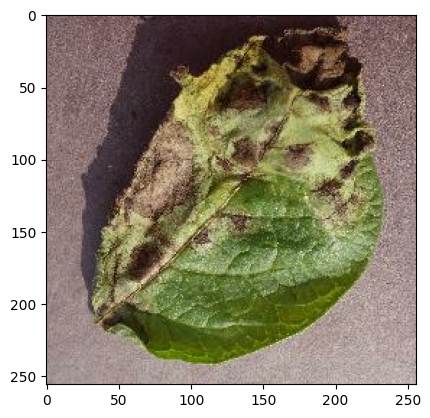

In [ ]:
for images_batch, labels_batch in test_ds.take(1):
    

    first_image = images_batch[0].numpy().astype("uint8")
    
    print("Predicting the first image")
    plt.imshow(first_image)
    print("Label:",labels_batch[0].numpy())

    batch_prediction = model.predict(images_batch)
    print(batch_prediction[0])

Predicting the first image
Actual Label: 1
1/1 [==============================] - 0s 287ms/step
Predicted Label: 1


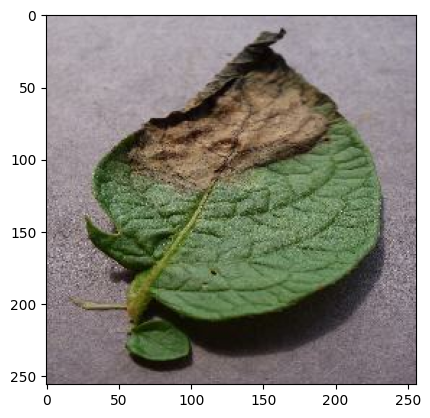

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    print("Predicting the first image")
    plt.imshow(first_image)
    print("Actual Label:",labels_batch[0].numpy())

    batch_prediction = model.predict(images_batch)
    print("Predicted Label:", np.argmax(batch_prediction[0]))

Predicting the first image
Actual Label: Potato___Early_blight
1/1 [==============================] - 0s 303ms/step
Predicted Label: Potato___Early_blight


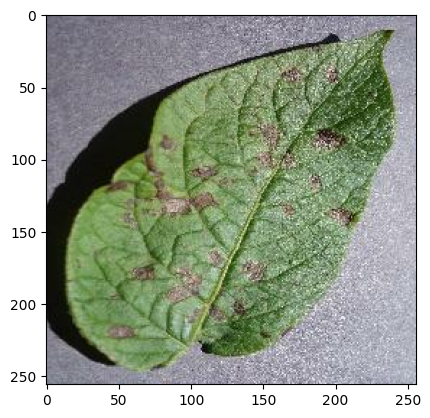

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    print("Predicting the first image")
    plt.imshow(first_image)
    print("Actual Label:",class_names[labels_batch[0].numpy()])

    batch_prediction = model.predict(images_batch)
    print("Predicted Label:", class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Creating a batch
    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 *  (np.max(predictions[0])), 2)
    return predicted_class, confidence 

1/1 [==============================] - 0s 78ms/step


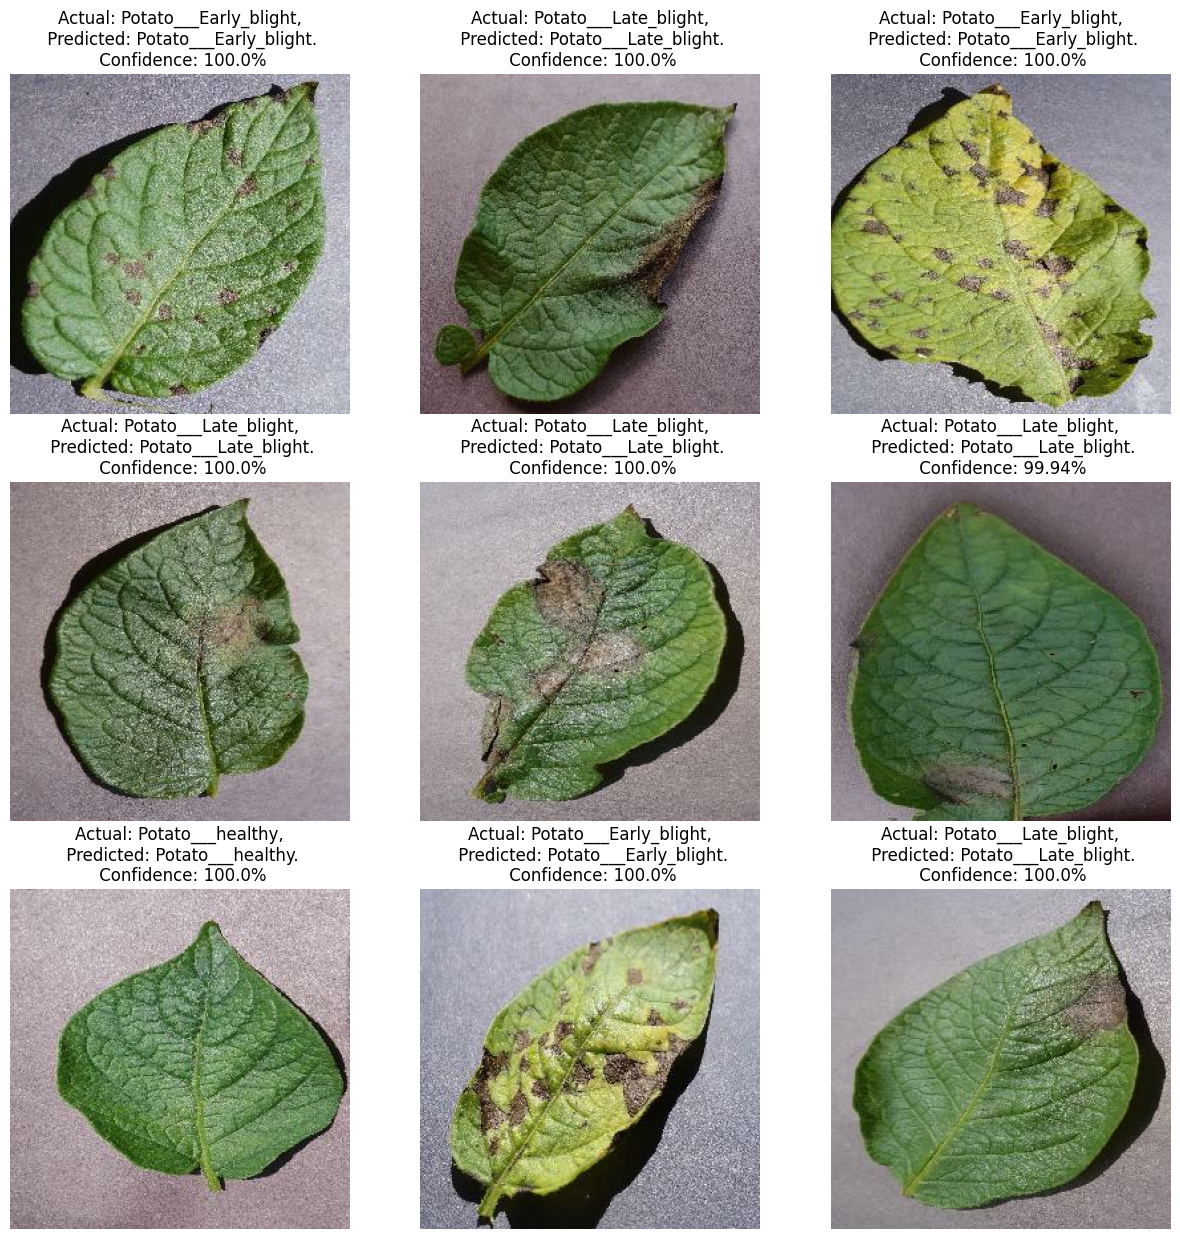

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())

        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [ ]:
import os
from pathlib import Path

# Ensure the models directory exists
models_directory = "../models"
Path(models_directory).mkdir(parents=True, exist_ok=True)

# List comprehension to get only directories with integer names in "../models"
directories = [d for d in os.listdir(models_directory) if os.path.isdir(os.path.join(models_directory, d)) and d.isdigit()]

# If there are directories, find the maximum version, otherwise, set version to 0
model_version = max([int(d) for d in directories] + [0], default=0) + 1

# Ensure the version directory exists
model_version_directory = os.path.join(models_directory, str(model_version))
Path(model_version_directory).mkdir(parents=True, exist_ok=True)

# Save the model with the determined version
try:
    model.save(model_version_directory)
    print(f"Model saved successfully to: {model_version_directory}")
except Exception as e:
    print(f"Error saving model: {e}")


INFO:tensorflow:Assets written to: ../models\6\assets


INFO:tensorflow:Assets written to: ../models\6\assets


Model saved successfully to: ../models\6


In [ ]:
model.save("../models/{}/".format(model_version))



INFO:tensorflow:Assets written to: ../models/6/assets


INFO:tensorflow:Assets written to: ../models/6/assets


In [ ]:
import os
print(os.path.abspath(f"../models/{model_version}"))


C:\Users\KIIT\documents\models\4
